In [ ]:
%pip install roboflow tensorflow matplotlib numpy

In [1]:
# ==========================================
# CELL 0: AUTO-LOAD ALL IMPORTS, CONFIG, DATA, MODEL & BACKUPS
# ==========================================
# Jalankan cell ini SEKALI di awal. Semua backup + data + model akan auto-load.
# Setelah ini, langsung ke Cell 1 (Training/Resume).

import os
import math
import matplotlib.pyplot as plt
import pandas as pd
import json
from datetime import datetime
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf
import numpy as np
import random

# ==========================================
# KONFIGURASI
# ==========================================
IMG_WIDTH = 224
IMG_HEIGHT = 224
BATCH_SIZE = 32
EPOCHS = 20

data_root_dir = r"C:\Users\Lenovo\Downloads\Vehicle_classification\week6_proj.v1i.multiclass"

train_dir = os.path.join(data_root_dir, 'train')
val_dir = os.path.join(data_root_dir, 'valid')
test_dir = os.path.join(data_root_dir, 'test')

backup_dir = "model_backups"
os.makedirs(backup_dir, exist_ok=True)

model_checkpoint_path = os.path.join(backup_dir, "model_checkpoint.h5")
history_backup_path = os.path.join(backup_dir, "training_history.json")
initial_epoch_path = os.path.join(backup_dir, "initial_epoch.txt")

print("="*60)
print("AUTO-LOAD: Imports, Config, Data, Model & Backups")
print("="*60)
print("Dataset dengan 3 kelas: Bus, Car, Motorcycle")
print("Direktori: {}".format(data_root_dir))

# ==========================================
# DETECT & LOAD BACKUPS
# ==========================================
has_checkpoint = os.path.exists(model_checkpoint_path)
has_history = os.path.exists(history_backup_path)
has_epoch = os.path.exists(initial_epoch_path)

initial_epoch = 0
history_dict = {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}

if has_checkpoint and has_history and has_epoch:
    print("\n✓ Backup ditemukan!")
    with open(initial_epoch_path, 'r') as f:
        initial_epoch = int(f.read().strip())
    with open(history_backup_path, 'r') as f:
        history_dict = json.load(f)
    print("  Last completed epoch: {}".format(initial_epoch))
    print("  Epochs trained: {}".format(len(history_dict['loss'])))
else:
    print("\n→ Belum ada backup. Training fresh dari epoch 0.")

# ==========================================
# AUTO-LOAD DATA GENERATORS
# ==========================================
print("\n✓ Loading Data Generators...")

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.25,
    height_shift_range=0.25,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.2,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

# Load Training Data
train_csv = os.path.join(train_dir, '_classes.csv')
train_df = pd.read_csv(train_csv)
label_cols = [c for c in train_df.columns if c != 'filename']
train_df['class'] = train_df[label_cols].idxmax(axis=1)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=train_dir,
    x_col='filename',
    y_col='class',
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

# Load Validation Data
val_csv = os.path.join(val_dir, '_classes.csv')
validation_df = pd.read_csv(val_csv)
label_cols_val = [c for c in validation_df.columns if c != 'filename']
validation_df['class'] = validation_df[label_cols_val].idxmax(axis=1)
validation_generator = val_test_datagen.flow_from_dataframe(
    dataframe=validation_df,
    directory=val_dir,
    x_col='filename',
    y_col='class',
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Load Test Data
test_csv = os.path.join(test_dir, '_classes.csv')
test_df = pd.read_csv(test_csv)
label_cols_test = [c for c in test_df.columns if c != 'filename']
test_df['class'] = test_df[label_cols_test].idxmax(axis=1)
test_generator = val_test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=test_dir,
    x_col='filename',
    y_col='class',
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Get class names
class_names = list(train_generator.class_indices.keys())
print("  Kelas: {}".format(class_names))
print("  Training: {} | Validation: {} | Test: {}".format(
    train_generator.samples, validation_generator.samples, test_generator.samples))

# ==========================================
# AUTO-LOAD/BUILD MODEL
# ==========================================
print("\n✓ Loading/Building Model...")

if os.path.exists(model_checkpoint_path):
    print("  Loading model dari checkpoint...")
    model = tf.keras.models.load_model(model_checkpoint_path)
    print("  ✓ Model loaded dari checkpoint")
else:
    print("  Building MobileNetV2 model baru...")
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))
    base_model.trainable = False
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.4)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    predictions = Dense(len(class_names), activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=Adam(learning_rate=0.00005),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    print("  ✓ Model built untuk {} kelas".format(len(class_names)))

print("\n" + "="*60)
print("READY: Jalankan Cell 1 (Training) untuk mulai/resume training")
print("="*60)


AUTO-LOAD: Imports, Config, Data, Model & Backups
Dataset dengan 3 kelas: Bus, Car, Motorcycle
Direktori: C:\Users\Lenovo\Downloads\Vehicle_classification\week6_proj.v1i.multiclass

→ Belum ada backup. Training fresh dari epoch 0.

✓ Loading Data Generators...
Found 525 validated image filenames belonging to 3 classes.
Found 39 validated image filenames belonging to 3 classes.
Found 39 validated image filenames belonging to 3 classes.
Found 31 validated image filenames belonging to 3 classes.
Found 31 validated image filenames belonging to 3 classes.
  Kelas: ['Bus', 'Car', 'Motorcycle']
  Training: 525 | Validation: 39 | Test: 31

✓ Loading/Building Model...
  Building MobileNetV2 model baru...
  Kelas: ['Bus', 'Car', 'Motorcycle']
  Training: 525 | Validation: 39 | Test: 31

✓ Loading/Building Model...
  Building MobileNetV2 model baru...
  ✓ Model built untuk 3 kelas

READY: Jalankan Cell 1 (Training) untuk mulai/resume training
  ✓ Model built untuk 3 kelas

READY: Jalankan Cell 1 


TRAINING: Epoch 0/20

→ Training fresh dari epoch 0
Epoch 1/20
Epoch 1/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 686ms/step - accuracy: 0.4078 - loss: 1.1670
Epoch 1: saving model to model_backups\model_checkpoint.h5

Epoch 1: saving model to model_backups\model_checkpoint.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 19s 829ms/step - accuracy: 0.4590 - loss: 1.0999 - val_accuracy: 0.6923 - val_loss: 0.8168
Epoch 2/20
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 621ms/step - accuracy: 0.5961 - loss: 0.8559
Epoch 2: saving model to model_backups\model_checkpoint.h5

Epoch 2: saving model to model_backups\model_checkpoint.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 672ms/step - accuracy: 0.6114 - loss: 0.8451 - val_accuracy: 0.8462 - val_loss: 0.6215
Epoch 3/20
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 639ms/step - accuracy: 0.6871 - loss: 0.7753
Epoch 3: saving model to model_backups\model_checkpoint.h5

Epoch 3: saving model to model_backups\model_checkpoint.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 12s 696ms/step - accuracy: 0.7048 - loss: 0.7214 - val_accuracy: 0.9487 - val_loss: 0.4752
Epoch 4/20
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 618ms/step - accuracy: 0.7725 - loss: 0.5980
Epoch 4: saving model to model_backups\model_checkpoint.h5

Epoch 4: saving model to model_backups\model_checkpoint.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 12s 668ms/step - accuracy: 0.7981 - loss: 0.5641 - val_accuracy: 0.9744 - val_loss: 0.3703
Epoch 5/20
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 602ms/step - accuracy: 0.8251 - loss: 0.5066
Epoch 5: saving model to model_backups\model_checkpoint.h5

Epoch 5: saving model to model_backups\model_checkpoint.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 653ms/step - accuracy: 0.8495 - loss: 0.4795 - val_accuracy: 1.0000 - val_loss: 0.2932
Epoch 6/20
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 602ms/step - accuracy: 0.8546 - loss: 0.4370
Epoch 6: saving model to model_backups\model_checkpoint.h5

Epoch 6: saving model to model_backups\model_checkpoint.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 650ms/step - accuracy: 0.8667 - loss: 0.4108 - val_accuracy: 1.0000 - val_loss: 0.2322
Epoch 7/20
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 629ms/step - accuracy: 0.9036 - loss: 0.3470
Epoch 7: saving model to model_backups\model_checkpoint.h5

Epoch 7: saving model to model_backups\model_checkpoint.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 12s 678ms/step - accuracy: 0.8781 - loss: 0.3599 - val_accuracy: 1.0000 - val_loss: 0.1835
Epoch 8/20
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 641ms/step - accuracy: 0.9240 - loss: 0.2870
Epoch 8: saving model to model_backups\model_checkpoint.h5

Epoch 8: saving model to model_backups\model_checkpoint.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 690ms/step - accuracy: 0.9162 - loss: 0.3011 - val_accuracy: 1.0000 - val_loss: 0.1471
Epoch 9/20
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 633ms/step - accuracy: 0.9623 - loss: 0.2340
Epoch 9: saving model to model_backups\model_checkpoint.h5

Epoch 9: saving model to model_backups\model_checkpoint.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 683ms/step - accuracy: 0.9505 - loss: 0.2440 - val_accuracy: 1.0000 - val_loss: 0.1206
Epoch 10/20
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 612ms/step - accuracy: 0.9046 - loss: 0.2826
Epoch 10: saving model to model_backups\model_checkpoint.h5

Epoch 10: saving model to model_backups\model_checkpoint.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 661ms/step - accuracy: 0.9181 - loss: 0.2717 - val_accuracy: 1.0000 - val_loss: 0.0986
Epoch 11/20
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 602ms/step - accuracy: 0.9427 - loss: 0.2359
Epoch 11: saving model to model_backups\model_checkpoint.h5

Epoch 11: saving model to model_backups\model_checkpoint.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 651ms/step - accuracy: 0.9448 - loss: 0.2178 - val_accuracy: 1.0000 - val_loss: 0.0796
Epoch 12/20
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 611ms/step - accuracy: 0.9689 - loss: 0.1690
Epoch 12: saving model to model_backups\model_checkpoint.h5

Epoch 12: saving model to model_backups\model_checkpoint.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 662ms/step - accuracy: 0.9543 - loss: 0.1852 - val_accuracy: 1.0000 - val_loss: 0.0653
Epoch 13/20
Epoch 13/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 607ms/step - accuracy: 0.9558 - loss: 0.1781
Epoch 13: saving model to model_backups\model_checkpoint.h5

Epoch 13: saving model to model_backups\model_checkpoint.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 656ms/step - accuracy: 0.9448 - loss: 0.1935 - val_accuracy: 1.0000 - val_loss: 0.0551
Epoch 14/20
Epoch 14/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 681ms/step - accuracy: 0.9548 - loss: 0.1880
Epoch 14: saving model to model_backups\model_checkpoint.h5

Epoch 14: saving model to model_backups\model_checkpoint.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 13s 747ms/step - accuracy: 0.9543 - loss: 0.1677 - val_accuracy: 1.0000 - val_loss: 0.0489
Epoch 15/20
Epoch 15/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 741ms/step - accuracy: 0.9451 - loss: 0.1419
Epoch 15: saving model to model_backups\model_checkpoint.h5

Epoch 15: saving model to model_backups\model_checkpoint.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 14s 794ms/step - accuracy: 0.9543 - loss: 0.1473 - val_accuracy: 1.0000 - val_loss: 0.0435
Epoch 16/20
Epoch 16/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 632ms/step - accuracy: 0.9770 - loss: 0.1200
Epoch 16: saving model to model_backups\model_checkpoint.h5

Epoch 16: saving model to model_backups\model_checkpoint.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 12s 685ms/step - accuracy: 0.9600 - loss: 0.1483 - val_accuracy: 1.0000 - val_loss: 0.0375
Epoch 17/20
Epoch 17/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 742ms/step - accuracy: 0.9609 - loss: 0.1247
Epoch 17: saving model to model_backups\model_checkpoint.h5

Epoch 17: saving model to model_backups\model_checkpoint.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 13s 798ms/step - accuracy: 0.9600 - loss: 0.1149 - val_accuracy: 1.0000 - val_loss: 0.0326
Epoch 18/20
Epoch 18/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 730ms/step - accuracy: 0.9632 - loss: 0.1109
Epoch 18: saving model to model_backups\model_checkpoint.h5

Epoch 18: saving model to model_backups\model_checkpoint.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 13s 789ms/step - accuracy: 0.9619 - loss: 0.1252 - val_accuracy: 1.0000 - val_loss: 0.0297
Epoch 19/20
Epoch 19/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 697ms/step - accuracy: 0.9663 - loss: 0.1165
Epoch 19: saving model to model_backups\model_checkpoint.h5

Epoch 19: saving model to model_backups\model_checkpoint.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 13s 759ms/step - accuracy: 0.9562 - loss: 0.1436 - val_accuracy: 1.0000 - val_loss: 0.0283
Epoch 20/20
Epoch 20/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 643ms/step - accuracy: 0.9567 - loss: 0.1341
Epoch 20: saving model to model_backups\model_checkpoint.h5

Epoch 20: saving model to model_backups\model_checkpoint.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 12s 694ms/step - accuracy: 0.9695 - loss: 0.1137 - val_accuracy: 1.0000 - val_loss: 0.0275

✓ Training history disimpan
✓ Epoch file diupdate

✓ Training history disimpan
✓ Epoch file diupdate


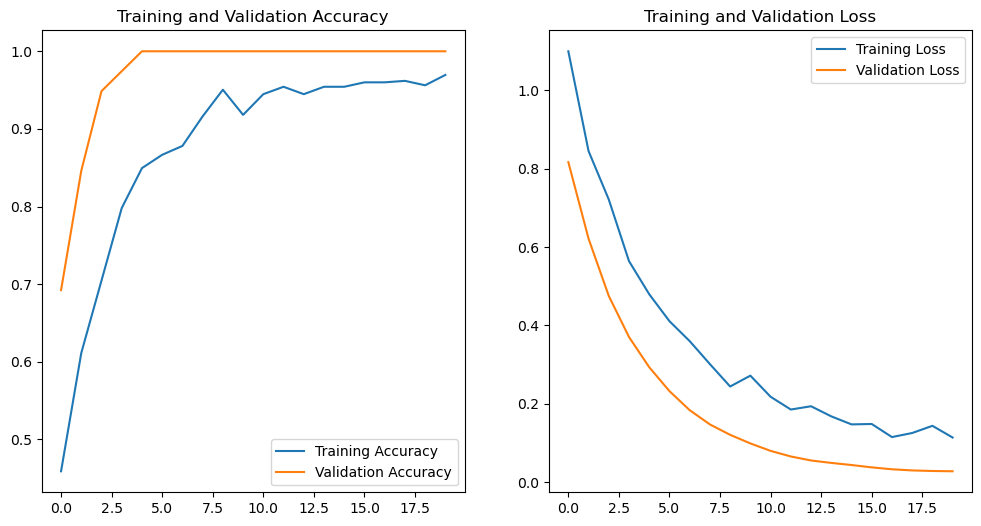


✓ Final model disimpan: vehicle_classifier_model.h5


In [2]:
# ==========================================
# CELL 1: TRAINING MODEL (Standalone - Resume atau Fresh)
# ==========================================
# Jalankan cell ini untuk mulai/resume training
# Semua backup + data + model sudah auto-load dari Cell 0

print("\n" + "="*60)
print("TRAINING: Epoch {}/{}".format(initial_epoch, EPOCHS))
print("="*60)

if has_checkpoint:
    print("\n✓ Resume dari epoch {}".format(initial_epoch))
else:
    print("\n→ Training fresh dari epoch 0")

# Setup checkpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath=model_checkpoint_path,
    monitor='val_loss',
    save_best_only=False,
    verbose=1
)

# Train
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    initial_epoch=initial_epoch,
    validation_data=validation_generator,
    steps_per_epoch=math.ceil(train_generator.samples / BATCH_SIZE),
    validation_steps=math.ceil(validation_generator.samples / BATCH_SIZE),
    callbacks=[checkpoint_callback]
)

# Update dan simpan history
for key in ['accuracy', 'loss', 'val_accuracy', 'val_loss']:
    if key in history.history:
        history_dict[key].extend(history.history[key])

with open(history_backup_path, 'w') as f:
    json.dump(history_dict, f, indent=2)
print("\n✓ Training history disimpan")

# Update epoch file
with open(initial_epoch_path, 'w') as f:
    f.write(str(EPOCHS))
print("✓ Epoch file diupdate")

# ==========================================
# PLOT HASIL
# ==========================================
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Simpan Model Final
save_path = "vehicle_classifier_model.h5"
model.save(save_path)
print("\n✓ Final model disimpan: {}".format(save_path))
print("="*60)


In [3]:
# ==========================================
# CELL 2: EVALUATE MODEL
# ==========================================
# Jalankan cell ini untuk evaluate model pada test set

print("\nEvaluating the model on the test dataset...")
loss, accuracy = model.evaluate(test_generator,
                                steps=math.ceil(test_generator.samples / BATCH_SIZE))

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
print("="*60)



Evaluating the model on the test dataset...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 522ms/step - accuracy: 1.0000 - loss: 0.0319
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 522ms/step - accuracy: 1.0000 - loss: 0.0319
Test Loss: 0.0319
Test Accuracy: 1.0000
Test Loss: 0.0319
Test Accuracy: 1.0000


In [4]:
# ==========================================
# CELL 3: PREDICTION FUNCTION
# ==========================================
# Helper function untuk predict pada single image

def predict_image(image_path, model, class_names):
    print(f"\nPredicting for image: {image_path}")
    
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(IMG_WIDTH, IMG_HEIGHT))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0

    predictions = model.predict(img_array, verbose=0)
    predicted_class_index = np.argmax(predictions[0])
    predicted_class_name = class_names[predicted_class_index]
    confidence = predictions[0][predicted_class_index] * 100

    print(f"Predicted: {predicted_class_name} (Confidence: {confidence:.2f}%)")

    plt.figure(figsize=(6, 6))
    img_display = plt.imread(image_path)
    plt.imshow(img_display)
    plt.title(f"Predicted: {predicted_class_name} ({confidence:.2f}%)")
    plt.axis('off')
    plt.show()

    return predicted_class_name, confidence



Random sample: C:\Users\Lenovo\Downloads\Vehicle_classification\week6_proj.v1i.multiclass\test\2014-Nissan-Titan_-Click-here-for-a-quote-4-_jpg.rf.d1fcb481fd4aab1ea33d5f9c7a0f6560.jpg

Predicting for image: C:\Users\Lenovo\Downloads\Vehicle_classification\week6_proj.v1i.multiclass\test\2014-Nissan-Titan_-Click-here-for-a-quote-4-_jpg.rf.d1fcb481fd4aab1ea33d5f9c7a0f6560.jpg
Predicted: Car (Confidence: 91.53%)
Predicted: Car (Confidence: 91.53%)


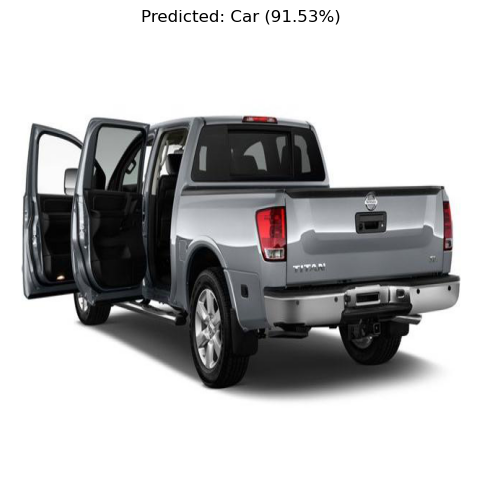

In [5]:
# ==========================================
# CELL 4: SAMPLE PREDICTION
# ==========================================
# Jalankan cell ini untuk test prediction pada random sample dari test set
# CATATAN: Cell 0 harus dijalankan TERLEBIH DAHULU

# Safety check: ensure Cell 0 has been run
if 'test_generator' not in locals():
    print("ERROR: test_generator not found!")
    print("LANGKAH PERBAIKAN: Jalankan Cell 0 (AUTO-LOAD) terlebih dahulu")
    print("Setelah Cell 0 selesai, jalankan cell ini lagi.")
else:
    all_test_image_paths = test_generator.filepaths
    existing_test_image_paths = [path for path in all_test_image_paths if os.path.exists(path)]

    if existing_test_image_paths:
        sample_image_path = random.choice(existing_test_image_paths)
        print(f"\nRandom sample: {sample_image_path}")
        predicted_class, confidence = predict_image(sample_image_path, model, class_names)
    else:
        print("Could not find any valid sample images in the test set.")
